<a href="https://colab.research.google.com/github/lescipi/Thesis/blob/master/Neural%20Process%20Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will train a Neural Process on a set of regression tasks:
the aim of each task is to asppoximate a function. The common traint of all 
tasks (i.e. functions to approximate) is that they are generated by a sine
function. What varies across tasks is the amplitude and the period

<img src="https://www.mathsisfun.com/algebra/images/period-amplitude.svg" alt="period and amplitude">

using the formula

$$y = a \cdot \text{sin}\left(bx\right)$$

where $a$ is the amplitude and $2\pi/b$ is the period.

In [0]:
# Load required packages

import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Sizes
  x: torch.Size([25]) 
  y: torch.Size([25]) 
for each task


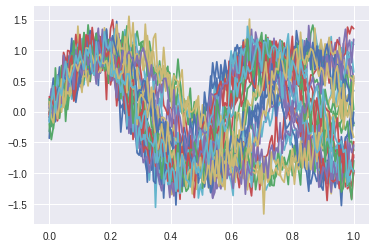

In [0]:
# Create dataset for each task
torch.manual_seed(19051994)
datasets = {}
n_tasks = 30
period = []

truth_x = torch.linspace(0, 1, 150)
x = torch.linspace(0, 1, 25)

for i in range(n_tasks):
    a = np.random.uniform(2, 4)
    y = torch.sin(a * np.pi * x) + torch.randn(x.size()) * 0.2
    truth_y = torch.sin(a * np.pi * truth_x) + torch.randn(truth_x.size()) * 0.2
    datasets['task_{}'.format(i)] = y.unsqueeze(-1), truth_y.unsqueeze(-1)
    plt.plot(truth_x.numpy(), truth_y.numpy())
print('Sizes\n', ' x:', x.shape, '\n  y:', y.shape, '\nfor each task')
plt.show()

In [0]:
x_dim = 1
y_dim = 1

# Define dimension of latent representations
r_dim = 3
z_dim = 3

# Define encoder specs
encoder_specs = [(10, torch.nn.Tanh()), 
                 (10, torch.nn.Tanh()), 
                 (r_dim, None)]

# Define decoder specs
decoder_specs = [(10, torch.nn.Tanh()), 
                 (10, torch.nn.Tanh()), 
                 (y_dim, None)]

encoder_input_dim = x_dim + y_dim 
decoder_input_dim = x_dim + z_dim

# Define entire structure of the model
h = nep.Encoder(encoder_input_dim, encoder_specs, init_func=torch.nn.init.kaiming_normal_)
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(decoder_input_dim, decoder_specs, init_func=torch.nn.init.kaiming_normal_)

# Define ADAM optimizer
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=1e-3)

In [0]:
epochs = 10000
kl = []
elbo = []

x_t = x.unsqueeze(-1)
truth_x = truth_x.unsqueeze(-1)

Epoch: 0


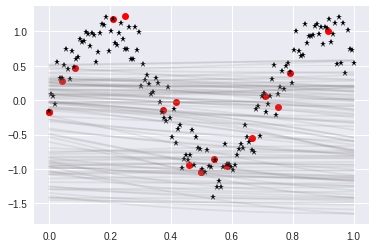

Epoch: 1000


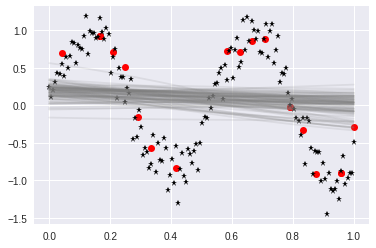

Epoch: 2000


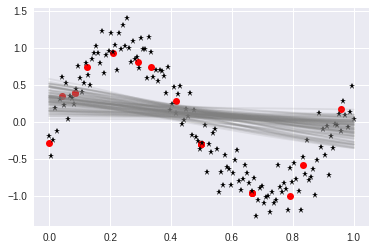

Epoch: 3000


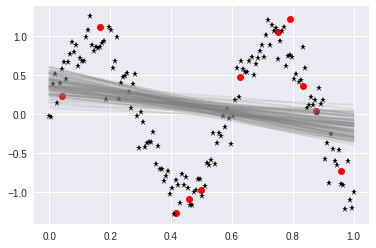

Epoch: 4000


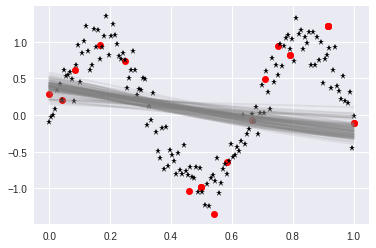

Epoch: 5000


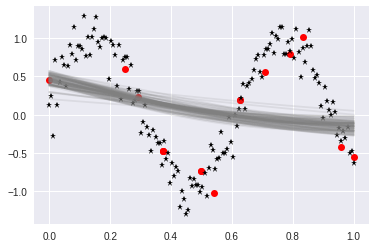

Epoch: 6000


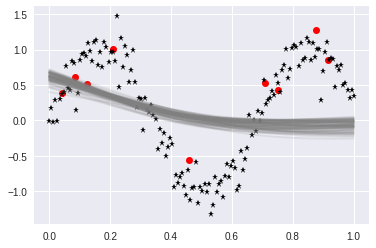

Epoch: 7000


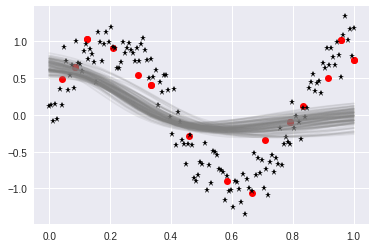

Epoch: 8000


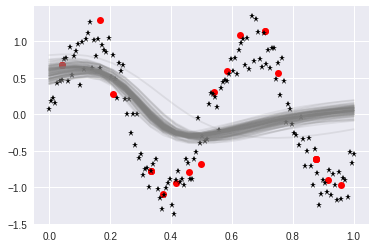

Epoch: 9000


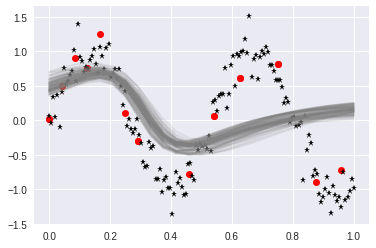

Training successful


In [0]:
# Meta-Training

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # select a task randomly
    task_id = 'task_' + str(np.random.randint(n_tasks))
    y_t, truth_y = datasets[task_id]
    
    # select number of context points randomly
    n_context = np.random.randint(1, x_t.shape[0])
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.randint(x_t.shape[0], size=n_context)
    x_c = x_t[context_indeces]
    y_c = y_t[context_indeces]

    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_t, y_t))   
    z_std_t = z_std_t
    
    # compute loglikelihood
    log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    
    # compute KL divergence
    KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
    
    # compute ELBO
    ELBO = - log_likelihood + KL
    
    # compute derivatives (backpropagation)
    ELBO.backward()
    
    # take gradient step
    optimizer.step()  
    
    # store values
    kl.append(KL)
    elbo.append(ELBO)

    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(x_t, g, z_mean_t, z_std_t, 100)

        plt.plot(x_c.numpy(), y_c.numpy(), 'ro')
        plt.plot(truth_x.numpy(), truth_y.numpy(), 'k*')
        for i in y_pred:
            plt.plot(x.numpy(), i, 'grey', alpha=0.15) 
        plt.show()

print('Training successful')

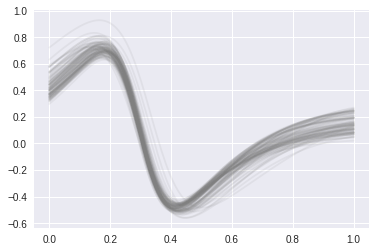

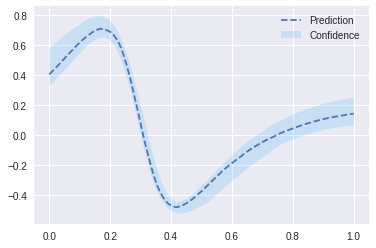

In [0]:
y_pred = nep.predict(truth_x, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)


# Plot learned distribution over functions 
# (prior to be used on new task)

## Format 1
for i in y_pred:
    plt.plot(truth_x.numpy(), i, 'grey', alpha=0.1)   
plt.show()
    
## Format 2
plt.plot(truth_x.numpy().flatten(), median.flatten(), '--')
plt.fill_between(truth_x.numpy().flatten(), quantile_05.flatten(), quantile_95.flatten(), alpha=0.15, facecolor='#089FFF')
plt.legend(['Prediction', 'Confidence'])
plt.show()

In [0]:
# Create new task and sample 10 datapoint (observed)
index_train = np.random.choice(y.shape[0], 10, replace=False)
y_new = torch.sin(3.5 * np.pi * x) + torch.randn(x.size()) * 0.2
y_new = y_new.unsqueeze(-1)
x_new = x.unsqueeze(-1)
y_new_train = y_new[index_train]
x_new_train = x_new[index_train]
print(index_train.shape)

(10,)


Epoch: 0


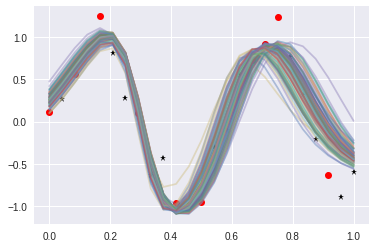

Training successful


In [0]:
epochs = 1000

# Meta-Testing

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # select number of context points randomly
    n_context = np.random.randint(1, y_new_train.shape[0])
    
    # select `n_context` points and create the context set and target set
    context_indeces = np.random.choice(y_new_train.shape[0], n_context, replace=False)
    x_c = x_new_train[context_indeces]
    y_c = y_new_train[context_indeces]

    # variational parameters (mean, std) of approximate prior
    z_mean_c, z_std_c = r_to_z(h(x_c, y_c))
    
    # variational parameters (mean, std) of approximate posterior
    z_mean_t, z_std_t = r_to_z(h(x_new_train, y_new_train))
    
    # Monte Carlo estimate of log-likelihood (expectation wrt approximate posterior)
    log_likelihood = nep.MC_loglikelihood(x_t, y_t, g, z_mean_t, z_std_t, 10)
    
    # Compute KL divergence analytically
    KL = nep.KL_div(z_mean_t, z_std_t, z_mean_c, z_std_c) 
    
    # compute negative ELBO
    ELBO = - log_likelihood + KL
    
    # compute gradient of ELBO and take gradient step
    ELBO.backward()
    optimizer.step()   
    
    # store values
    kl.append(KL)
    elbo.append(ELBO)
    
    if epoch % 1000 == 0:
        print('Epoch:', epoch)
        y_pred = nep.predict(x_new, g, z_mean_t, z_std_t, 100)

        plt.plot(x_new.numpy(), y_new.numpy(), 'k*')
        plt.plot(x_new_train.numpy(), y_new_train.numpy(), 'ro')
        for i in y_pred:
            plt.plot(x_new.numpy(), i, alpha=0.4) 
        plt.show()
        
print('Training successful')

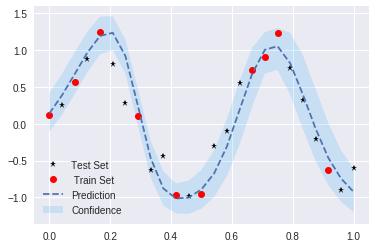

In [0]:
# Plot posterior over functions
y_pred = nep.predict(x_new, g, z_mean_t, z_std_t, 100)
quantile_05, median, quantile_95 = np.percentile(y_pred, [5, 50, 95], axis=0)

plt.plot(x_new.numpy(), y_new.numpy(), 'k*')
plt.plot(x_new_train.numpy(), y_new_train.numpy(), 'ro')
plt.plot(x_new.numpy().flatten(), median.flatten(), '--')
plt.fill_between(x_new.numpy().flatten(), quantile_05.flatten()-0.2, quantile_95.flatten()+0.2, alpha=0.15, facecolor='#089FFF')
plt.legend(['Test Set', ' Train Set', 'Prediction', 'Confidence'])
plt.show()